In [1]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

from matplotlib.patches import Ellipse
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset
import torchvision

import zipfile
import os
import shutil
from typing import List, Tuple

from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import pairwise_distances

import umap

The idea of using a Gaussian Mixture Model for testing is to split the data into subclasses within existing classes using a Gaussian Mixture Model. This is done to deal with the problem of high intra-class variance
and small inter-cluster dissimilarity while evaluating the quality of the generated images.

# Downloading the data

In [2]:
with zipfile.ZipFile("/content/minefree-class-split-wo-borders.zip", 'r') as zip_ref:
    zip_ref.extractall("data")

In [3]:
source_dirs = ['./data/minefree-class-split-wo-borders/test/bombed', './data/minefree-class-split-wo-borders/train/bombed']
target_dir = './data/bombed'
os.makedirs(target_dir, exist_ok=True)

for src in source_dirs:
    for file_name in os.listdir(src):
        full_file_name = os.path.join(src, file_name)
        if os.path.isfile(full_file_name):
            shutil.copy(full_file_name, target_dir)

In [4]:
source_dirs = ['./data/minefree-class-split-wo-borders/test/not bombed', './data/minefree-class-split-wo-borders/train/not bombed']
target_dir = './data/not bombed'
os.makedirs(target_dir, exist_ok=True)

for src in source_dirs:
    for file_name in os.listdir(src):
        full_file_name = os.path.join(src, file_name)
        if os.path.isfile(full_file_name):
            shutil.copy(full_file_name, target_dir)

# Gaussian Mixture Model

In [5]:
def make_positive_definite(S_k: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    S_k = 0.5 * (S_k + S_k.T)
    # 2) get real eigenvalues
    eigs = torch.linalg.eigvalsh(S_k)
    min_eig = eigs.min()
    # 3) if it’s already ≥ eps, do nothing; else shift by (eps - min_eig)
    if min_eig < eps:
        S_k = S_k + (eps - min_eig) * torch.eye(S_k.size(0), device=S_k.device)
    return S_k

In [6]:
import torch
import torch.nn as nn
import numpy as np
from typing import List, Tuple


def _to_tensor(array: np.ndarray) -> torch.Tensor:
    return torch.from_numpy(np.array(array, dtype=np.float32))


class MultivariateGaussian(nn.Module):
    def __init__(
        self,
        dim: int,
        mu: np.ndarray = None,
        R: np.ndarray = None,
        reg_covar: float = 1e-6,
        eps: float = 1e-7
    ):
        super().__init__()
        self.dim = dim
        self.reg_covar = reg_covar
        self.eps = eps

        # Initialize mean vector
        if mu is None:
            mu = np.zeros(dim, dtype=np.float32)
        else:
            mu = mu.astype(np.float32)
        self.mu = nn.Parameter(torch.from_numpy(mu))

        # Initialize Cholesky factor R
        if R is None:
            L = torch.randn(dim, dim)
            L = torch.tril(L)
            L.diagonal().abs_().add_(self.eps + self.reg_covar)
            self.R = nn.Parameter(L)
        else:
            R = R.astype(np.float32)
            self.R = nn.Parameter(torch.from_numpy(R))

    def Sigma(self) -> torch.Tensor:
        return self.R @ self.R.T

    def log_likelihood(self, x: torch.Tensor) -> torch.Tensor:
        cov = self.Sigma()
        # enforce symmetry
        cov = (cov + cov.T) / 2
        # sklearn-style: diagonal loading
        eye = torch.eye(self.dim, device=cov.device, dtype=cov.dtype)
        cov = cov + (self.reg_covar + self.eps) * eye

        mvn = torch.distributions.MultivariateNormal(self.mu, covariance_matrix=cov)
        return mvn.log_prob(x)

    def sample(self, sample_shape=torch.Size()) -> torch.Tensor:
        cov = self.Sigma()
        cov = (cov + cov.T) / 2
        eye = torch.eye(self.dim, device=cov.device, dtype=cov.dtype)
        cov = cov + (self.reg_covar + self.eps) * eye
        mvn = torch.distributions.MultivariateNormal(self.mu, covariance_matrix=cov)
        return mvn.sample(sample_shape)


def log_responsibilities(model: nn.Module, data: torch.Tensor) -> torch.Tensor:
    priors = torch.softmax(model.prior, dim=0) if model.use_softmax else model.prior
    log_priors = torch.log(priors + 1e-12)
    comp_ll = [log_priors[i] + model.gaussians[i].log_likelihood(data) for i in range(model.K)]
    nom = torch.stack(comp_ll, dim=0)
    return nom - torch.logsumexp(nom, dim=0)


class GaussianMixtureModel(nn.Module):
    def __init__(
        self,
        dim: int,
        K: int,
        prior: np.ndarray = None,
        mus: List[np.ndarray] = None,
        sigmas: List[np.ndarray] = None,
        use_softmax: bool = False,
        reg_covar: float = 1e-6,
        eps: float = 1e-7
    ):
        super().__init__()
        self.dim = dim
        self.K = K
        self.use_softmax = use_softmax
        self.reg_covar = reg_covar
        self.eps = eps

        self.gaussians = nn.ModuleList([
            MultivariateGaussian(dim, mu=None, R=None, reg_covar=reg_covar, eps=eps)
            for _ in range(K)
        ])

        self.set_params(prior, mus, sigmas)

    @torch.no_grad()
    def predict_proba(self, x: torch.Tensor) -> torch.Tensor:
        log_r = log_responsibilities(self, x)
        r = torch.exp(log_r)
        return (r / r.sum(dim=0, keepdim=True)).T

    @torch.no_grad()
    def predict(self, x: torch.Tensor) -> torch.Tensor:
        proba = self.predict_proba(x)
        return proba.argmax(dim=1)

    def set_params(
        self,
        prior: torch.Tensor | np.ndarray = None,
        mus: List[torch.Tensor | np.ndarray] = None,
        sigmas: List[torch.Tensor | np.ndarray] = None
    ) -> None:
        # Mixture weights
        if prior is None:
            p = np.full(self.K, 1.0 / self.K, dtype=np.float32)
        else:
            p = prior.detach().cpu().numpy().astype(np.float32) if isinstance(prior, torch.Tensor) else np.array(prior, dtype=np.float32)
        self.prior = nn.Parameter(_to_tensor(p))

        # Component means
        if mus is not None:
            for i, m in enumerate(mus):
                m_t = m.detach().cpu().to(torch.float32) if isinstance(m, torch.Tensor) else _to_tensor(m)
                self.gaussians[i].mu = nn.Parameter(m_t)

        # Component covariances with robust cholesky
        if sigmas is not None:
            for i, S in enumerate(sigmas):
                S_t = S.clone().to(torch.float32) if isinstance(S, torch.Tensor) else torch.from_numpy(np.array(S, dtype=np.float32))
                cov = 0.5 * (S_t + S_t.T)
                eye = torch.eye(self.dim, device=cov.device, dtype=cov.dtype)
                cov = cov + (self.reg_covar + self.eps) * eye
                # Try cholesky, increase jitter on failure
                try:
                    L = torch.linalg.cholesky(cov)
                except RuntimeError:
                    jitter = self.reg_covar + self.eps
                    for _ in range(5):
                        jitter *= 10
                        cov_j = cov + jitter * eye
                        try:
                            L = torch.linalg.cholesky(cov_j)
                            break
                        except RuntimeError:
                            continue
                    else:
                        raise RuntimeError("Covariance not PD even after jitter")
                self.gaussians[i].R = nn.Parameter(L)


    def log_likelihood(self, x: torch.Tensor) -> torch.Tensor:
        priors = torch.softmax(self.prior, dim=0) if self.use_softmax else self.prior
        log_priors = torch.log(priors + 1e-12)
        comp_ll = [log_priors[i] + self.gaussians[i].log_likelihood(x) for i in range(self.K)]
        stacked = torch.stack(comp_ll, dim=0)
        return torch.logsumexp(stacked, dim=0)

    def sample(self) -> torch.Tensor:
        prior = torch.softmax(self.prior, dim=0) if self.use_softmax else self.prior
        idx = torch.distributions.Categorical(probs=prior).sample().item()
        return self.gaussians[idx].sample()


def update_params(model: GaussianMixtureModel, log_resp: torch.Tensor, data: np.ndarray):
    # compute responsibilities and detach to avoid grad->numpy
    resp = torch.exp(log_resp).clamp_min(1e-8).detach()
    resp /= resp.sum(dim=0, keepdim=True)
    N_k = resp.sum(dim=1).clamp_min(1e-6)

    # convert data once to torch tensor
    X = torch.tensor(data, dtype=torch.float32, device=resp.device)

    priors = N_k / X.size(0)
    mus, sigmas = [], []
    for k in range(model.K):
        r_k = resp[k].unsqueeze(1)  # (N,1)
        mu_k = (r_k * X).sum(dim=0) / N_k[k]
        mus.append(mu_k)

        diff = X - mu_k
        S_k = (r_k * diff).T @ diff / N_k[k]
        # symmetrize + diagonal loading
        S_k = 0.5 * (S_k + S_k.T)
        eye = torch.eye(model.dim, device=S_k.device, dtype=S_k.dtype)
        S_k = S_k + (model.reg_covar + model.eps) * eye
        sigmas.append(S_k)

    model.set_params(prior=priors, mus=mus, sigmas=sigmas)


def initialize_gmm(data: np.ndarray, K: int) -> GaussianMixtureModel:
    N, D = data.shape
    return GaussianMixtureModel(dim=D, K=K)


def fit_gmm(model: GaussianMixtureModel, data: np.ndarray, limit: int = 10000, delta: float = 1e-8):
    model.train()
    data_t = torch.tensor(data, dtype=torch.float32, device=model.gaussians[0].mu.device)
    history = []
    for i in range(limit):
        log_resp = log_responsibilities(model, data_t)
        update_params(model, log_resp, data)
        loss = -torch.mean(model.log_likelihood(data_t))
        history.append(loss.item())
        print(f"Iteration {i}, Loss: {loss.item()}")
        if i > 0 and abs(history[-1] - history[-2]) < delta:
            break
    return model, data_t, history


# Extracting features from the images

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [9]:
data_paths = {
    "bombed": "data/bombed",
    "not_bombed": "data/not bombed"
}

In [10]:
def load_dataloader(path):
    dataset = datasets.ImageFolder(root=os.path.dirname(path), transform=transform)
    class_name = os.path.basename(path)
    class_idx = dataset.class_to_idx[class_name]
    indices = [i for i, (_, y) in enumerate(dataset.samples) if y == class_idx]
    subset = torch.utils.data.Subset(dataset, indices)
    return DataLoader(subset, batch_size=16, shuffle=True)

In [11]:
bombed_loader = load_dataloader(data_paths["bombed"])
not_bombed_loader = load_dataloader(data_paths["not_bombed"])

In [12]:
resnet = torchvision.models.resnet18(pretrained=True)
resnet.fc = nn.Identity()
resnet.eval()
resnet.to("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 275MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
def extract_features(model, dataloader, device='cpu', max_batches=None):
    features_list = []
    labels_list = []
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader):
            images = images.to(device)
            feats = model(images)
            features_list.append(feats.cpu())
            labels_list.append(labels)
            if max_batches and i >= max_batches:
                break
    return torch.cat(features_list), torch.cat(labels_list)

features_bombed, labels_bombed = extract_features(resnet, bombed_loader, device=device, max_batches=100)
features_not_bombed, labels_not_bombed = extract_features(resnet, not_bombed_loader, device=device, max_batches=100)

In [14]:
pca = PCA(n_components=50, svd_solver='auto')
combined_train = np.concatenate([features_bombed, features_not_bombed], axis=0)
pca.fit(combined_train)

features_reduced = pca.transform(features_bombed)
features_reduced_1 = pca.transform(features_not_bombed)

# Fitting the GMM

In [15]:
def dunn_index(X, labels):
    """
    Compute the Dunn Index for clustering.

    Parameters:
        X : array-like, shape (n_samples, n_features)
        labels : array-like, shape (n_samples,)

    Returns:
        float: Dunn Index.
    """
    X = np.asarray(X)
    labels = np.asarray(labels)
    unique_labels = np.unique(labels)
    dist_mat = pairwise_distances(X)

    # intra-cluster diameters
    diameters = []
    for lbl in unique_labels:
        idx = np.where(labels == lbl)[0]
        if len(idx) <= 1:
            diameters.append(0.0)
        else:
            diameters.append(np.max(dist_mat[np.ix_(idx, idx)]))
    max_diameter = np.max(diameters)

    # inter-cluster distances
    min_inter = np.inf
    for i, lbl_i in enumerate(unique_labels):
        for lbl_j in unique_labels[i+1:]:
            idx_i = np.where(labels == lbl_i)[0]
            idx_j = np.where(labels == lbl_j)[0]
            if idx_i.size and idx_j.size:
                dists = dist_mat[np.ix_(idx_i, idx_j)]
                min_inter = min(min_inter, np.min(dists))

    return min_inter / max_diameter

def evaluate_gmm(X, labels):
    """
    Compute common clustering evaluation metrics for a GMM.

    Parameters:
        X : array-like, shape (n_samples, n_features)
        labels : array-like, shape (n_samples,)

    Returns:
        dict: {
            'silhouette': float,
            'davies_bouldin': float,
            'calinski_harabasz': float,
            'dunn': float
        }
    """
    X = np.asarray(X)
    labels = np.asarray(labels)
    scores = {}
    scores['silhouette'] = silhouette_score(X, labels)
    scores['davies_bouldin'] = davies_bouldin_score(X, labels)
    scores['calinski_harabasz'] = calinski_harabasz_score(X, labels)
    scores['dunn'] = dunn_index(X, labels)
    return scores

In [16]:
# # elbow method
# def elbow_method(X, max_k=10):
#     """
#     Compute the elbow method for GMM.

#     Parameters:
#         X : array-like, shape (n_samples, n_features)
#         max_k : int, maximum number of clusters to consider
#     """
#     X = np.asarray(X)
#     scores = []
#     for k in range(1, max_k + 1):
#         gmm = GaussianMixtureModel(dim=X.shape[1], K=k)
#         gmm, _, _ = fit_gmm(gmm, X)
#         log_likelihood = gmm.log_likelihood(torch.tensor(X, dtype=torch.float32))
#         scores.append(log_likelihood.mean().item())
#     return scores
# def plot_elbow(scores, max_k=10):
#     """
#     Plot the elbow method results.
#     """
#     plt.figure(figsize=(8, 6))
#     plt.plot(range(1, max_k + 1), scores, marker='o')
#     plt.title('Elbow Method for Optimal k')
#     plt.xlabel('Number of clusters (k)')
#     plt.ylabel('Log Likelihood')
#     plt.grid()
#     plt.show()
# scores = elbow_method(features_reduced, max_k=10)
# plot_elbow(scores, max_k=10)

In [17]:
# # BIC and AIC for different k
# def bic_aic(X, max_k=10):
#     """
#     Compute BIC and AIC for GMM.

#     Parameters:
#         X : array-like, shape (n_samples, n_features)
#         max_k : int, maximum number of clusters to consider
#     """
#     X = np.asarray(X)
#     bic_scores = []
#     aic_scores = []
#     for k in range(1, max_k + 1):
#         gmm = GaussianMixtureModel(dim=X.shape[1], K=k)
#         gmm, _, _ = fit_gmm(gmm, X)
#         log_likelihood = gmm.log_likelihood(torch.tensor(X, dtype=torch.float32))
#         n_params = k * (X.shape[1] + 1) + k * (X.shape[1] * (X.shape[1] + 1)) / 2
#         bic = -2 * log_likelihood.mean().item() + n_params * np.log(X.shape[0])
#         aic = -2 * log_likelihood.mean().item() + 2 * n_params
#         bic_scores.append(bic)
#         aic_scores.append(aic)
#     return bic_scores, aic_scores
# def plot_bic_aic(bic_scores, aic_scores, max_k=10):
#     """
#     Plot BIC and AIC scores.
#     """
#     plt.figure(figsize=(8, 6))
#     plt.plot(range(1, max_k + 1), bic_scores, marker='o', label='BIC')
#     plt.plot(range(1, max_k + 1), aic_scores, marker='o', label='AIC')
#     plt.title('BIC and AIC for GMM')
#     plt.xlabel('Number of clusters (k)')
#     plt.ylabel('Score')
#     plt.legend()
#     plt.grid()
#     plt.show()
# bic_scores, aic_scores = bic_aic(features_reduced, max_k=10)
# plot_bic_aic(bic_scores, aic_scores, max_k=10)

Firstly, let's fit the gmm for the bombed class.

In [19]:
K = 2
indices = np.random.choice(len(features_bombed), K, replace=False)
sample_points = features_reduced[indices]
gmm_bombed = initialize_gmm(features_reduced, K=K)

D = features_reduced.shape[1]
I = np.eye(D, dtype=np.float32)
init_S = [I for _ in range(K)]
gmm_bombed.set_params(mus=sample_points, sigmas=init_S)

gmm_bombed, X_tensor, em_hist = fit_gmm(gmm_bombed, features_reduced)

X_np = X_tensor.numpy() # shape (n_samples, n_features)
labels = gmm_bombed.predict(X_tensor).cpu().numpy()
metrics = evaluate_gmm(X_np, labels)
print(f"Number of clusters: {K}")
print(f"Silhouette: {metrics['silhouette']}")
print(f"Davies-Bouldin: {metrics['davies_bouldin']}")
print(f"Calinski-Harabasz: {metrics['calinski_harabasz']}")
print(f"Dunn: {metrics['dunn']}")

Iteration 0, Loss: 57.88187026977539
Iteration 1, Loss: 56.81999969482422
Iteration 2, Loss: 56.071102142333984
Iteration 3, Loss: 55.39671325683594
Iteration 4, Loss: 55.08717346191406
Iteration 5, Loss: 54.75975799560547
Iteration 6, Loss: 54.41167449951172
Iteration 7, Loss: 54.174556732177734
Iteration 8, Loss: 54.144996643066406
Iteration 9, Loss: 54.14495086669922
Iteration 10, Loss: 54.14493942260742
Iteration 11, Loss: 54.144927978515625
Iteration 12, Loss: 54.144866943359375
Iteration 13, Loss: 54.14313888549805
Iteration 14, Loss: 54.10496139526367
Iteration 15, Loss: 54.09824752807617
Iteration 16, Loss: 54.09251022338867
Iteration 17, Loss: 54.036231994628906
Iteration 18, Loss: 54.00937271118164
Iteration 19, Loss: 54.00047302246094
Iteration 20, Loss: 53.93283462524414
Iteration 21, Loss: 53.93240737915039
Iteration 22, Loss: 53.93240737915039
Number of clusters: 2
Silhouette: 0.22640544176101685
Davies-Bouldin: 1.8068260788014583
Calinski-Harabasz: 147.96719360351562
Dun

In [20]:
X = np.asarray(features_reduced, dtype=np.float32)

# 1.2 Check for bad values
assert np.isfinite(X).all(), "X contains NaN or infinite values"

# 1.3 Flatten your labels
labels = np.asarray(labels).ravel()
assert labels.shape[0] == X.shape[0]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(n_jobs=1, n_neighbors=100, random_state=42, verbose=True)
Wed May  7 16:36:52 2025 Construct fuzzy simplicial set
Wed May  7 16:36:52 2025 Finding Nearest Neighbors
Wed May  7 16:36:52 2025 Finished Nearest Neighbor Search
Wed May  7 16:36:52 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Wed May  7 16:36:54 2025 Finished embedding


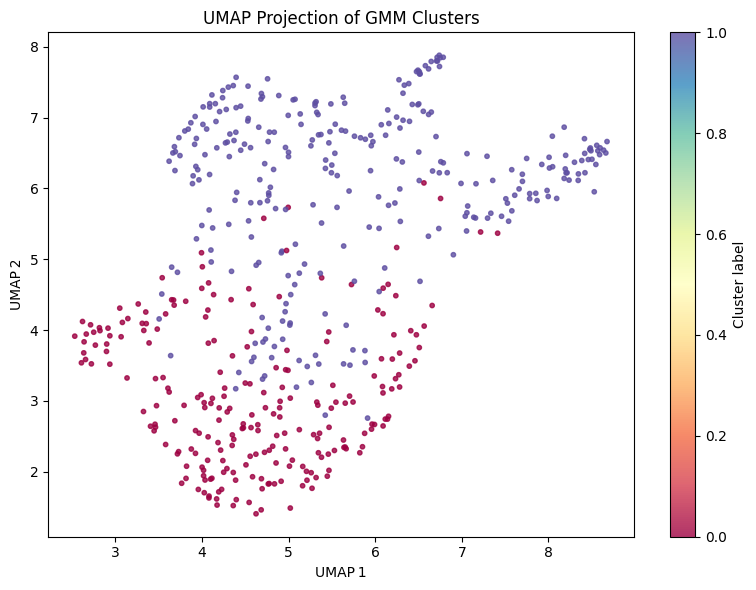

In [21]:
def plot_umap(X, labels, title=None,
              n_neighbors=15, min_dist=0.1, metric='euclidean',
              random_state=42):
    """
    Plot the 2D UMAP embedding of X, colored by labels.

    Parameters:
        X : array-like, shape (n_samples, n_features)
        labels : array-like, shape (n_samples,)
        title : str, optional
        n_neighbors : int, how many neighbors UMAP uses (balances local/global)
        min_dist : float, how tightly UMAP packs points (0.0–1.0)
        metric : str or callable, distance metric
        random_state : int, reproducibility seed
    """
    # 1) clean inputs
    X = np.asarray(X, dtype=np.float32)
    if not np.isfinite(X).all():
        raise ValueError("Input X contains NaN or infinite values")
    labels = np.asarray(labels).ravel()
    if labels.shape[0] != X.shape[0]:
        raise ValueError("labels length must match number of samples")

    # 2) embed
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=2,
        metric=metric,
        random_state=random_state,
        verbose=True
    )
    embedding = reducer.fit_transform(X)

    # 3) plot
    plt.figure(figsize=(8, 6))
    sc = plt.scatter(
        embedding[:, 0], embedding[:, 1],
        c=labels, cmap='Spectral', s=10, alpha=0.8
    )
    plt.title(title or "UMAP Projection")
    plt.colorbar(sc, label="Cluster label")
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.tight_layout()
    plt.show()
plot_umap(X, labels, title="UMAP Projection of GMM Clusters", n_neighbors=100, min_dist=0.1, metric='euclidean', random_state=42)

In [22]:
K = 1

sample_mean = np.mean(features_reduced_1, axis=0, keepdims=True)
sample_std = np.std(features_reduced_1, axis=0, keepdims=True)

gmm_not_bombed = initialize_gmm(features_reduced_1, K=K)

D = features_reduced_1.shape[1]
cov_matrix = np.diagflat(sample_std[0]**2).astype(np.float32)
init_S = [cov_matrix for _ in range(K)]

gmm_not_bombed.set_params(mus=sample_mean.astype(np.float32), sigmas=init_S)

gmm_not_bombed, X_tensor, em_hist = fit_gmm(gmm_not_bombed, features_reduced_1)

Iteration 0, Loss: 60.040767669677734
Iteration 1, Loss: 60.040767669677734


# Testing for real data

Let's upload the generated data:

In [23]:
with zipfile.ZipFile("/content/generated_data.zip", 'r') as zip_ref:
    zip_ref.extractall("generated_data")

In [24]:
data_paths = {
    "bombed": "generated_data/generated_data/bombed",
    "not_bombed": "generated_data/generated_data/not_bombed"
}

In [25]:
gen_bombed_loader = load_dataloader(data_paths["bombed"])
gen_not_bombed_loader = load_dataloader(data_paths["not_bombed"])

In [26]:
features_gen_bombed, labels_bombed = extract_features(resnet, gen_bombed_loader, device=device, max_batches=100)
features_gen_not_bombed, labels_not_bombed = extract_features(resnet, gen_not_bombed_loader, device=device, max_batches=100)

In [27]:
generated_reduced = pca.transform(features_gen_bombed)
generated_reduced_1 = pca.transform(features_gen_not_bombed)

In [28]:
def mahalanobis_distances(point: np.ndarray, gmm: GaussianMixtureModel) -> torch.Tensor:
    point = torch.tensor(point, dtype=torch.float32, device=gmm.gaussians[0].mu.device)
    distances = []
    for i in range(gmm.K):
        gaussian = gmm.gaussians[i]
        mu = gaussian.mu
        cov = gaussian.Sigma()
        cov = (cov + cov.T) / 2  # enforce symmetry
        cov += (gmm.reg_covar + gmm.eps) * torch.eye(gmm.dim, device=cov.device)

        cov_inv = torch.linalg.inv(cov)
        diff = point - mu
        dist = torch.sqrt(diff @ cov_inv @ diff)
        distances.append(dist)
    return torch.stack(distances)

In [29]:
true_predict = 0
differences = []

for point in generated_reduced:

  distances_bombed = mahalanobis_distances(point, gmm_bombed)
  distances_not_bombed = mahalanobis_distances(point, gmm_not_bombed)

  min_dist_bombed = torch.min(distances_bombed)
  min_dist_not_bombed = torch.min(distances_not_bombed)

  predicted_bombed = min_dist_bombed < min_dist_not_bombed

  if predicted_bombed:
     true_predict += 1

n = len(features_gen_bombed.numpy())
print(f"Mahalanobis accuracy: {100 * true_predict / n:.2f}%")

Mahalanobis accuracy: 78.57%


In [30]:
true_predict = 0
differences = []

for point in generated_reduced_1:
  distances_bombed = mahalanobis_distances(point, gmm_bombed)
  distances_not_bombed = mahalanobis_distances(point, gmm_not_bombed)

  min_dist_bombed = torch.min(distances_bombed)
  min_dist_not_bombed = torch.min(distances_not_bombed)

  predicted_not_bombed = min_dist_not_bombed < min_dist_bombed

  if predicted_not_bombed:
     true_predict += 1

n = len(features_gen_not_bombed.numpy())
print(f"Mahalanobis accuracy: {100 * true_predict / n:.2f}%")

Mahalanobis accuracy: 10.65%
